In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import cv2


In [2]:
# Paths
dataset_path = 'Data_Set'
train_dir = 'Data_Set/Train'
val_dir = 'Data_Set/Validation'

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

classes = ['glioma_tumor', 'meningioma_tumor', 'Normal', 'pituitary_tumor']
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)


In [3]:
# Function to split and save images to respective folders
def split_and_save_images(class_name):
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Move training images
    for img in train_images:
        shutil.move(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

    # Move validation images
    for img in val_images:
        shutil.move(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

# Apply the function to all classes
for cls in classes:
    split_and_save_images(cls)


In [4]:
# Image data generators for augmenting the data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load images
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(150, 150),
                                                batch_size=32,
                                                class_mode='categorical')


Found 17335 images belonging to 4 classes.
Found 4337 images belonging to 4 classes.


In [5]:
# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


D:\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping callback to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model checkpoint callback to save the best model weights
checkpoint = ModelCheckpoint('model_checkpoint.weights.h5', 
                              monitor='val_loss', 
                              save_best_only=True, 
                              save_weights_only=True, 
                              verbose=1)

# Train the model
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=val_generator,
                    callbacks=[early_stop, checkpoint])


Epoch 1/30


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.3758 - loss: 1.2799
Epoch 1: val_loss improved from inf to 1.12523, saving model to model_checkpoint.weights.h5
542/542 ━━━━━━━━━━━━━━━━━━━━ 263s 480ms/step - accuracy: 0.3759 - loss: 1.2798 - val_accuracy: 0.5038 - val_loss: 1.1252
Epoch 2/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.5082 - loss: 1.0914
Epoch 2: val_loss improved from 1.12523 to 0.89164, saving model to model_checkpoint.weights.h5
542/542 ━━━━━━━━━━━━━━━━━━━━ 279s 512ms/step - accuracy: 0.5083 - loss: 1.0914 - val_accuracy: 0.6318 - val_loss: 0.8916
Epoch 3/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.5634 - loss: 1.0012
Epoch 3: val_loss improved from 0.89164 to 0.84297, saving model to model_checkpoint.weights.h5
542/542 ━━━━━━━━━━━━━━━━━━━━ 313s 575ms/step - accuracy: 0.5634 - loss: 1.0011 - val_accuracy: 0.6401 - val_loss: 0.8430
Epoch 4/30
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.5993 - loss: 0.9277
Epoch 4: val

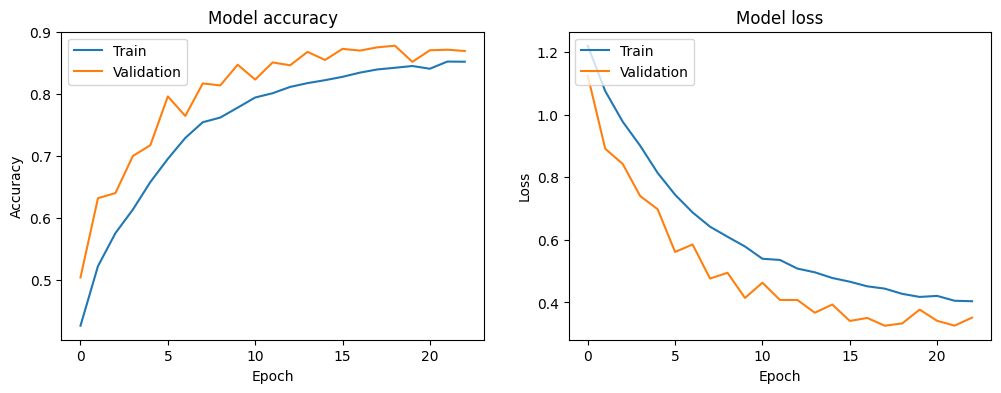

In [7]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [8]:
# Save the model
model.save('brain_tumor_detection_cnn.h5')
print("Model saved as 'brain_tumor_detection_cnn.h5'")


Model saved as 'brain_tumor_detection_cnn.h5'


In [12]:
# Load model for prediction
model = tf.keras.models.load_model('brain_tumor_detection_cnn.h5')

# Example function to make predictions on new images
def predict_tumor(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (150, 150))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    class_idx = np.argmax(prediction, axis=1)[0]
    class_labels = train_generator.class_indices
    labels = dict((v, k) for k, v in class_labels.items())  # Reverse the dictionary
    
    return labels[class_idx]

# Test with a new image
print(predict_tumor('10 no.jpg'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Normal
